# Amazon Electronics 

This project is a simple prediction on whether a review is positive or negative one. \
In the first notebook i analyse a little bit the reviews. Just the reviews as this is an NPL problem. \ 
I also binarize the problem to two classes, good or bad, instead of 1 to 5 rating as in the original data. \
The data is in json format so i transform it into csv format.


In the second notebook i used Multinomial Naive Bayes models to do the predictions as well as transforming the data as needed. \
Finally i deployed the model to flask and test the model with self-made comments

In [2]:
#.json to csv
import pandas as pd
import gzip
import json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

data = getDF('Electronics_5.json.gz')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import re
import math

In [26]:
data.head()

,overall,verified,reviewText,summary,Binary_Overall
0,5.0,True,This is the best novel I have read in 2 or 3 y...,A star is born,1.0
1,3.0,True,"Pages and pages of introspection, in the style...",A stream of consciousness novel,0.0
2,5.0,False,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1.0
3,5.0,False,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,1.0
4,3.0,True,I was taken in by reviews that compared this b...,A dissenting view--In part.,0.0


In [27]:
data.shape

(6737497, 5)

Next i'll drop columns im not using. They provide good information, but i want the problem to be just reviews and target variable.
Also there are 6.7 millions observations, so i took 10% of all data as a sample, since my computer can't handle all and i didn't want to use cloud services.

In [5]:
data.drop(columns = ['reviewTime','reviewerID','asin','style','reviewerName','unixReviewTime','image',"vote"],inplace = True)

In [6]:
data.isnull().sum()/data.shape[0]

overall       0.000000
verified      0.000000
reviewText    0.000201
summary       0.000120
dtype: float64

In [7]:
data.dropna(axis = 0, how='any',inplace=True ) #drop nulls. they are too few

In [8]:
sample = data.sample(frac = 0.1 , replace=False, axis=0) # 10% of data

In [9]:
print("Data Size:   " , data.shape[0])
print("Sample Size: " , sample.shape[0])

Data Size:    6737497
Sample Size:  673750


In [10]:
sample.overall.value_counts() # scores

5.0    432237
4.0    113526
3.0     50584
1.0     46691
2.0     30712
Name: overall, dtype: int64

In [11]:
sample.verified.value_counts()   # verifications

True     603589
False     70161
Name: verified, dtype: int64

In [12]:
sample.dtypes

overall       float64
verified         bool
reviewText     object
summary        object
dtype: object

Text(0.5, 1.0, 'Distribution of Ratings in Sample')

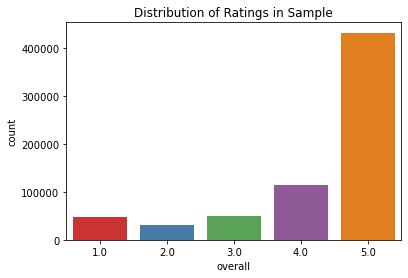

In [13]:
sns.countplot(x="overall", data=sample,palette="Set1").set_title("Distribution of Ratings in Sample")

Clearly the data is unbalanced. I'll binarize the problem, but still the data will remain unbalanced.

Text(0.5, 1.0, 'Distribution of Verified in Sample')

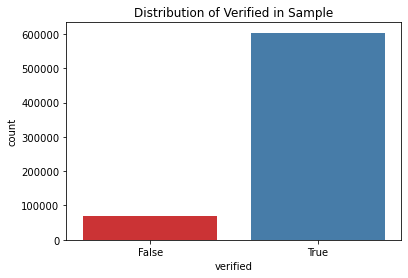

In [14]:
sns.countplot(x="verified", data=sample,palette="Set1").set_title("Distribution of Verified in Sample")

In [15]:
#show comments on each rating

def Show_Comments_Rating(rating,data_local):          
    
    data_Sample = data_local[data_local.overall == rating]
    return data_Sample

def Show_verified_ratings(rating,data_local):
    "Returns percentaje of verified observations and dataframe filtered base on provided rating"
    data_comments = Show_Comments_Rating(rating,data_local)
    data_verified = round(data_comments.verified.value_counts(normalize = True),2)
    return data_comments,data_verified

In [16]:
a,b = Show_verified_ratings(1,sample) 
print(b)
a.head(3)

True     0.83
False    0.17
Name: verified, dtype: float64


,overall,verified,reviewText,summary
6418094,1.0,True,it always falls off the wrist and won't even h...,it is not safe
2336538,1.0,True,"I didn't get a ticket or anything, but I drove...",Didn't work
862876,1.0,True,I bought this for a relative. When I received ...,Water?


In [17]:
a,b = Show_verified_ratings(2,sample)
print(b)
a.head(3)

True     0.85
False    0.15
Name: verified, dtype: float64


,overall,verified,reviewText,summary
901166,2.0,True,If you like watching jerky grainy video then t...,Functional but needy
945889,2.0,True,I really needed a flat pack case not an SD car...,Two Stars
1329178,2.0,True,I share a screen between a laptop and and desk...,"Half-Works, at best - use this tip"


In [18]:
a,b = Show_verified_ratings(3,sample) 
print(b)
a.head(3)

True     0.88
False    0.12
Name: verified, dtype: float64


,overall,verified,reviewText,summary
4526201,3.0,True,This product is a good solution for the price ...,good bluetooth solution for the price
1620417,3.0,True,to confusing to hook up wirelessly!,Three Stars
1400787,3.0,True,Got this to replace the broken CD/DVD driver i...,It's Okay


In [19]:
a,b = Show_verified_ratings(4,sample) 
print(b)
a.head(3)

True     0.88
False    0.12
Name: verified, dtype: float64


,overall,verified,reviewText,summary
4938976,4.0,True,"Works great, but seems a bit flimsy. Can't com...",Four Stars
4826973,4.0,False,This is actually really nice. Looks old fashio...,Love it!
3046058,4.0,True,Large view and small size makes these binocula...,They are easy to adjust and come with lens cov...


In [20]:
a,b = Show_verified_ratings(5,sample) 
print(b)
a.head(3)

True     0.91
False    0.09
Name: verified, dtype: float64


,overall,verified,reviewText,summary
2922662,5.0,True,This machine is not only beautiful and super f...,Beautiful design & no bloatware!
3311152,5.0,True,100% satisfied with the subwoofer.\n\nI was do...,Boom boom pow
1705027,5.0,True,Unbeatable for 7$ and change. Does what its su...,Cant beat it for the price


Next i'll binarize the problem. \
If the review has a value of 4 or 5, then is positive. \
If it's lower, then the review is a negative one.

In [21]:
data["Binary_Overall"] = np.NaN
data["Binary_Overall"] = np.where((data.overall == 5) | (data.overall == 4) ,1,data.Binary_Overall)
data.Binary_Overall.fillna(0,inplace = True)

In [22]:
a,b = Show_verified_ratings(1,data) 
a.head(3)

,overall,verified,reviewText,summary,Binary_Overall
29,1.0,True,Volume buttons were dead on arrival. be aware ...,One Star,0.0
55,1.0,True,Works great when I tape up the plug to the po...,plug falls out,0.0
56,1.0,True,Did not work. I'm sure the seller knew this be...,Do not buy!,0.0


In [23]:
a,b = Show_verified_ratings(5,data) 
a.head(3)

,overall,verified,reviewText,summary,Binary_Overall
0,5.0,True,This is the best novel I have read in 2 or 3 y...,A star is born,1.0
2,5.0,False,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1.0
3,5.0,False,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,1.0


Text(0.5, 1.0, 'Distribution of Positive and negatives reviews in data')

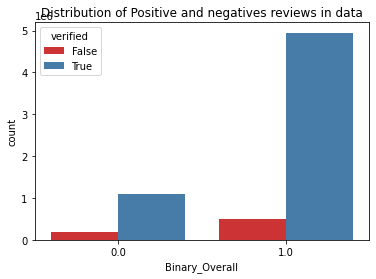

In [24]:
sns.countplot(x="Binary_Overall", data=data,palette="Set1",hue = "verified").set_title("Distribution of Positive and negatives reviews in data")

Verified people tend to give better reviews. \
Unbalanced classes

In [25]:
#import the csv
data.to_csv("Data.csv")